**Author**: Yap Jheng Khin

**FYP II Title**: Used car dealership web application

**Purpose**:
- This notebook trains and prepares the model to predict car price in used car dealership web application.
- Input: 
    - Car train and car test dataset. The notebook at https://colab.research.google.com/drive/1alFnJwZVOKntfmjxA0q8Rcni1irur5fn?usp=sharing explains how the data is scraped from a website and preprocessed.
- Ouput
    - Trained TRF. This is the model deployed in the web service. 
    - Pretrained ARF. 

**Technical jargon**
1. ARF - Adaptive random forest
2. TRF - Traditional random forest

**Execution time**: At most 5 minutes in Jupyter Notebook with 8 processor cores.

# Setup

Ensure that the current Python interpreter path is correct. For example, if the **River conda environment** is named as **arf_conda_env**, the expected `sys.executable` should be C:\Users\User\miniconda3\envs\\**arf_conda_env**\\python.exe.

In [1]:
import sys
print(sys.executable)

C:\Users\User\miniconda3\envs\arf_conda_env\python.exe


## Import

In [2]:
# Standard libraries
import math
import os
import pickle
import time

import numpy as np
import pandas as pd

# scikit-learn model
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# scikit-learn utilities
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline

# River model and its components
from river.ensemble import AdaptiveRandomForestRegressor
from river.drift import ADWIN

# User libraries
from data_preprocessing import DataPreprocessor
from arf_training import train_arf_rg
from arf_rg_transfer_learning import transfer_learning, transfer_tree_weights_test, dt_fetch_data
from rf_rg_performance_eval import measure_performance, analyze_trees

Initialize constants.

In [3]:
RANDOM_SEED = 2022
INPUT_FOLDER_PATH = 'inputs'
INPUT_TRAIN_DATASET = 'car_train.csv'
INPUT_TEST_DATASET = 'car_test.csv'

OUT_PARENT_DIR = 'outputs'
OUT_CHILD_DIR = 'car_price'
OUT_FOLDER_PATH = os.path.join(OUT_PARENT_DIR, OUT_CHILD_DIR) 

# Create directory if not exist
os.makedirs(OUT_FOLDER_PATH, exist_ok=True)

## Data Setup

The used car price data was scraped from https://www.carlist.my in 2021. After data cleaning and preprocessing, the dataset contains 8,534 train samples and 1,095 test samples. The dataset is splitted and stratified in advance to ensure that every categories exist in both train and test set.

Below is the description of each column:
<table>
      <tr>
            <th style="text-align:left;font-weight: bold;">No</th>
            <th style="text-align:left;font-weight: bold;">Feature Name</th>
            <th style="text-align:left;font-weight: bold;">Description</th>
            <th style="text-align:left;font-weight: bold;">Data type</th>
      </tr>
      <tr>
            <td style="text-align:left;">1</td>
            <td style="text-align:left;">manufacture_year</td>
            <td style="text-align:left;">Manufacturing year of the car</td>
            <td style="text-align:left;">Numeric</td>
      </tr>
      <tr>
            <td style="text-align:left;">2</td>
            <td style="text-align:left;">mileage</td>
            <td style="text-align:left;">The distance travelled by the car (in kilometer).</td>
            <td style="text-align:left;">Numeric</td>
      </tr>
      <tr>
            <td style="text-align:left;">3</td>
            <td style="text-align:left;">price</td>
            <td style="text-align:left;">The price of the car (in Ringgit Malaysia).</td>
            <td style="text-align:left;">Numeric</td>
      </tr>
      <tr>
            <td style="text-align:left;">4</td>
            <td style="text-align:left;">length_mm</td>
            <td style="text-align:left;">The length of the car in millimeter.</td>
            <td style="text-align:left;">Numeric</td>
      </tr>
      <tr>
            <td style="text-align:left;">5</td>
            <td style="text-align:left;">engine_cc</td>
            <td style="text-align:left;">The engine capacity of the car.</td>
            <td style="text-align:left;">Numeric</td>
      </tr>
      <tr>
            <td style="text-align:left;">6</td>
            <td style="text-align:left;">aspiration</td>
            <td style="text-align:left;">Type of aspiration in the car engine. Possible values are Aspirated, Turbo intercooled, Twin-scroll turbo, Turbocharged, Turbo supercharged intercooled, Twin Turbo intercooled, Supercharged intercooled, Supercharged.</td>
            <td style="text-align:left;">Categorical</td>
      </tr>
      <tr>
            <td style="text-align:left;">7</td>
            <td style="text-align:left;">wheel_base_mm</td>
            <td style="text-align:left;">The wheel base of the car in millimeter.</td>
            <td style="text-align:left;">Numeric</td>
      </tr>
      <tr>
            <td style="text-align:left;">8</td>
            <td style="text-align:left;">width_mm</td>
            <td style="text-align:left;">The width of the car in millimeter.</td>
            <td style="text-align:left;">Numeric</td>
      </tr>
      <tr>
            <td style="text-align:left;">9</td>
            <td style="text-align:left;">direct_injection</td>
            <td style="text-align:left;">The direct injection in the car engine. Possible values are Multi-Point Injected, Direct Injection, Carburettor Single, Direct/Multi-point injection.</td>
            <td style="text-align:left;">Categorical</td>
      </tr>
      <tr>
            <td style="text-align:left;">10</td>
            <td style="text-align:left;">seat_capacity</td>
            <td style="text-align:left;">The number of available seats in the car.</td>
            <td style="text-align:left;">Numeric</td>
      </tr>
      <tr>
            <td style="text-align:left;">11</td>
            <td style="text-align:left;">peak_power_hp</td>
            <td style="text-align:left;">The horsepower/engine power of the car.</td>
            <td style="text-align:left;">Numeric</td>
      </tr>
      <tr>
            <td style="text-align:left;">12</td>
            <td style="text-align:left;">fuel_type</td>
            <td style="text-align:left;">The fuel type of the vehicle. Possible values are Petrol - Unleaded (ULP), Diesel, Hybrid, Petrol - Leaded.</td>
            <td style="text-align:left;">Categorical</td>
      </tr>
      <tr>
            <td style="text-align:left;">13</td>
            <td style="text-align:left;">steering_type</td>
            <td style="text-align:left;">The steering type of the car. Possible values are Rack and Pinion, Electronic Power Steering, Recirculating Ball, Hydraulic Power, Worm and Roller.</td>
            <td style="text-align:left;">Categorical</td>
      </tr>
      <tr>
            <td style="text-align:left;">14</td>
            <td style="text-align:left;">assembled</td>
            <td style="text-align:left;">The location where the car is assembled. Possible values are Locally Built, Official Import, Parallel Import.</td>
            <td style="text-align:left;">Categorical</td>
      </tr>
      <tr>
            <td style="text-align:left;">15</td>
            <td style="text-align:left;">height_mm</td>
            <td style="text-align:left;">The height of the car in millimeter.</td>
            <td style="text-align:left;">Numeric</td>
      </tr>
      <tr>
            <td style="text-align:left;">16</td>
            <td style="text-align:left;">peak_torque_nm</td>
            <td style="text-align:left;">The peak torque of the car engine in nanometer.</td>
            <td style="text-align:left;">Numeric</td>
      </tr>
      <tr>
            <td style="text-align:left;">17</td>
            <td style="text-align:left;">doors</td>
            <td style="text-align:left;">The number of doors that the car has.</td>
            <td style="text-align:left;">Numeric</td>
      </tr>
      <tr>
            <td style="text-align:left;">18</td>
            <td style="text-align:left;">brand</td>
            <td style="text-align:left;">The car brand. Possible values are Toyota, Honda, Proton, Perodua, Nissan, BMW, Mercedes-Benz, Mazda, Peugeot, Ford, Volkswagen, Mitsubishi, Kia, Volvo, Hyundai, MINI, Porsche, Subaru, Lexus, Land Rover, Renault, Jaguar.</td>
            <td style="text-align:left;">Categorical</td>
      </tr>
      <tr>
            <td style="text-align:left;">19</td>
            <td style="text-align:left;">colour</td>
            <td style="text-align:left;">The main colour of the car. Possible values are White, Black, Silver, Grey, Blue, Red, Gold, Brown,  -, Bronze, Purple, Orange, Green, Maroon, Yellow, Beige, Pink, Magenta.</td>
            <td style="text-align:left;">Categorical</td>
      </tr>
      <tr>
            <td style="text-align:left;">20</td>
            <td style="text-align:left;">model</td>
            <td style="text-align:left;">The model of the car. There are 360 possible values such as Alza, Myvi, Triton, Almera, CX-5, Ranger, XV, Iriz, HR-V, CR-Z. Run car_train['model'].value_counts() to see all the values.</td>
            <td style="text-align:left;">Categorical</td>
      </tr>
      <tr>
            <td style="text-align:left;">21</td>
            <td style="text-align:left;">transmission</td>
            <td style="text-align:left;">Either the car is Automatic or Manual.</td>
            <td style="text-align:left;">Categorical</td>
      </tr>
</table>

In [4]:
car_train = pd.read_csv(f'{INPUT_FOLDER_PATH}/{INPUT_TRAIN_DATASET}')
car_test = pd.read_csv(f'{INPUT_FOLDER_PATH}/{INPUT_TEST_DATASET}')

# Drop unique identifier
car_train = car_train.drop(columns='product_link-href', axis=1)
car_test = car_test.drop(columns='product_link-href', axis=1)
# Fix some typos
car_train.rename(columns={'tranmission':'transmission'}, inplace=True)
car_test.rename(columns={'tranmission':'transmission'}, inplace=True)

In [5]:
car_train.head(5)

,manufacture_year,mileage,price,length_mm,engine_cc,aspiration,wheel_base_mm,width_mm,direct_injection,seat_capacity,...,fuel_type,steering_type,assembled,height_mm,peak_torque_nm,doors,brand,colour,model,transmission
0,2015.0,250000.0,68800.0,5260.0,2494.0,Turbo intercooled,3085.0,1835.0,Direct Injection,5.0,...,Diesel,Rack and Pinion,Locally Built,1850.0,343.0,4.0,Toyota,Silver,Hilux,Manual
1,2014.0,5000.0,75800.0,5260.0,2494.0,Turbo intercooled,3085.0,1835.0,Direct Injection,5.0,...,Diesel,Rack and Pinion,Locally Built,1850.0,343.0,4.0,Toyota,Silver,Hilux,Automatic
2,2015.0,86412.0,75800.0,5260.0,2494.0,Turbo intercooled,3085.0,1835.0,Direct Injection,5.0,...,Diesel,Rack and Pinion,Locally Built,1850.0,343.0,4.0,Toyota,Silver,Hilux,Automatic
3,2015.0,90000.0,82800.0,5260.0,2494.0,Turbo intercooled,3085.0,1835.0,Direct Injection,5.0,...,Diesel,Rack and Pinion,Locally Built,1850.0,343.0,4.0,Toyota,White,Hilux,Automatic
4,2006.0,110000.0,42800.0,5255.0,2494.0,Turbo intercooled,3085.0,1835.0,Direct Injection,5.0,...,Diesel,Rack and Pinion,Locally Built,1810.0,260.0,4.0,Toyota,Black,Hilux,Manual


In [6]:
car_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8533 entries, 0 to 8532
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   manufacture_year  8533 non-null   float64
 1   mileage           8533 non-null   float64
 2   price             8533 non-null   float64
 3   length_mm         8533 non-null   float64
 4   engine_cc         8533 non-null   float64
 5   aspiration        8533 non-null   object 
 6   wheel_base_mm     8533 non-null   float64
 7   width_mm          8533 non-null   float64
 8   direct_injection  8533 non-null   object 
 9   seat_capacity     8533 non-null   float64
 10  peak_power_hp     8533 non-null   float64
 11  fuel_type         8533 non-null   object 
 12  steering_type     8533 non-null   object 
 13  assembled         8533 non-null   object 
 14  height_mm         8533 non-null   float64
 15  peak_torque_nm    8533 non-null   float64
 16  doors             8533 non-null   float64


### Preprocess Data

In [7]:
num_attrs = [
    'manufacture_year',
    'mileage',
    'length_mm',
    'engine_cc',
    'wheel_base_mm',
    'width_mm',
    'seat_capacity',
    'peak_power_hp',
    'height_mm',
    'peak_torque_nm',
    'doors'
]

cat_attrs = [
    'aspiration',
    'direct_injection',
    'fuel_type',
    'steering_type',
    'assembled',
    'brand',
    'colour',
    'model',
    'transmission'
]

target_attr = 'price'

The result below shows that the `model` has 360 number of categories. The TRF model training is fast as usual since it uses Cython which runs Python-syntax code with native C performance. However, the transfer learning algorithm, which implemented in CPython, is very slow and take up at most 20 minutes. It is because the splitter must be initialized and updated for each 360 one-hot encoded nominal features in each leaf node in each base learner. In addition, it is discovered that the `model` feature has very low feature importance using SHAP tree explainer. Thus, the `model` feature is discarded but remains as one of the input fields in the web application.

The difference between Cython and CPython are discussed in the <a href="https://www.quora.com/What-is-the-difference-between-Cython-and-CPython">online forum</a>.

In [8]:
result = pd.DataFrame(columns=['Feature', 'No. of Categories'])

for idx, cat_attr in enumerate(cat_attrs):
    cats = np.unique(car_train[cat_attr])
    result.loc[idx] = [cat_attr, len(cats)]
    
result

,Feature,No. of Categories
0,aspiration,8
1,direct_injection,4
2,fuel_type,4
3,steering_type,5
4,assembled,3
5,brand,22
6,colour,18
7,model,360
8,transmission,2


In [9]:
# Define a random number generator object
# Source: https://towardsdatascience.com/stop-using-numpy-random-seed-581a9972805f
rng = np.random.default_rng(RANDOM_SEED)

# Shuffle the dataset
car_train = car_train.reindex(rng.permutation(car_train.index))
car_train = car_train.reset_index(drop=True)

car_test = car_test.reindex(rng.permutation(car_test.index))
car_test = car_test.reset_index(drop=True)

cat_attrs.remove('model')

# Export the preprocessed dataset
car_train.to_csv(os.path.join(OUT_FOLDER_PATH, 'car_train_processed.csv'), index=False)
car_test.to_csv(os.path.join(OUT_FOLDER_PATH, 'car_test_processed.csv'), index=False)

car_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8533 entries, 0 to 8532
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   manufacture_year  8533 non-null   float64
 1   mileage           8533 non-null   float64
 2   price             8533 non-null   float64
 3   length_mm         8533 non-null   float64
 4   engine_cc         8533 non-null   float64
 5   aspiration        8533 non-null   object 
 6   wheel_base_mm     8533 non-null   float64
 7   width_mm          8533 non-null   float64
 8   direct_injection  8533 non-null   object 
 9   seat_capacity     8533 non-null   float64
 10  peak_power_hp     8533 non-null   float64
 11  fuel_type         8533 non-null   object 
 12  steering_type     8533 non-null   object 
 13  assembled         8533 non-null   object 
 14  height_mm         8533 non-null   float64
 15  peak_torque_nm    8533 non-null   float64
 16  doors             8533 non-null   float64


# Training

## TRF

Train a traditional random forest on the train set. Then, perform the transfer learning to transfer the training weights to the adaptive random forest.

Split the dataset into train and test set.

In [10]:
# Get X and y for train and test set
X_train = car_train.drop(columns=['model', target_attr], axis=1)
y_train = car_train[target_attr]
X_test = car_test.drop(columns=['model', target_attr], axis=1)
y_test = car_test[target_attr]

print(f'X_train shape {X_train.shape}')
print(f'y_train shape {y_train.shape}')
print(f'X_test shape {X_test.shape}')
print(f'y_test shape {y_test.shape}')

X_train shape (8533, 19)
y_train shape (8533,)
X_test shape (1094, 19)
y_test shape (1094,)


Below are the hyperparameters for traditional random forest.

In [11]:
trf_rg_params = {
    # Random forest hyperparameters
    'n_estimators': 100, # Train 100 decision trees
    'criterion': 'squared_error', # Use mean squared error as feature selection criterion
    'max_depth': None, # No restriction on the maximum depth of trees
    'max_features': 'sqrt', # The number of features to consider when looking for the best split
    'random_state': RANDOM_SEED,
    
    # Traditional random forest algorithm-specific hyperparameters
    'bootstrap': True, # Different subset of dataset in each tree
    'max_leaf_nodes': None, # Can produce unlimited number of leaf nodes
    'min_samples_leaf': 1, # Miminum number of samples required to be at leaf node
    'min_samples_split': 50, # Minimum number of samples to split node. Must match with grace period.
    'min_weight_fraction_leaf': 0.0, # Samples have equal weight at leaf node

    # Utility parameters
    'n_jobs': -1, # Use all available processors
    'verbose': 0,
    'warm_start': False, # Fit a whole new forest
}

Perform hyperparameter tunning to optimise TRF.

In [12]:
# Setup the data preprocessor
data_pp = DataPreprocessor(X_train, num_attrs, cat_attrs)

# Relevant hyperparameters to reduce generalisation errors
trf_rg_param_dist = {
    'n_estimators': [5, 10, 15, 20], # The number of decision trees
    'max_depth': [5, 10, 15, 20], # The maximum depth of decision trees
}

# Training
duration = 0
start = time.time()

trf_rg_cv = RandomizedSearchCV(
    RandomForestRegressor(**trf_rg_params), trf_rg_param_dist, 
    n_iter = 8, scoring = 'neg_mean_absolute_error', n_jobs = -1, 
    refit=True, cv = 10, verbose = 10, 
    random_state = RANDOM_SEED, return_train_score = False)

X_train_pp = data_pp.preprocess(X_train)

trf_rg_search = trf_rg_cv.fit(X_train_pp, y_train)

end = time.time()
duration += end - start
print(f'\nTime taken for tunning TRF: {duration} seconds')

Fitting 10 folds for each of 8 candidates, totalling 80 fits

Time taken for tunning TRF: 6.846006393432617 seconds


Fit the TRF using the best hyperparameter settings.

In [13]:
# Training
duration = 0
start = time.time()

# Update the hyperparameters
for param_name, param_value in trf_rg_search.best_params_.items():
    trf_rg_params[param_name] = param_value
# Define a regressor
trf_rg = RandomForestRegressor(**trf_rg_params)

trf_rg.fit(X_train_pp, y_train)

end = time.time()
duration += end - start

print(f'\nTime taken for training TRF: {duration} seconds')


Time taken for training TRF: 0.14201021194458008 seconds


Below is the overall description of the fitted TRF regressor.

In [14]:
total_depth = 0
total_estimators = trf_rg.n_estimators
print(f'The total number of base learners is {trf_rg.n_estimators}.')

for estimator in trf_rg.estimators_:
    total_depth += estimator.get_depth()

print(f'The depth of each base learner is {math.floor(total_depth/total_estimators)} on average.')

The total number of base learners is 15.
The depth of each base learner is 15 on average.


## ARF (Train from Scratch)

An ARF model is trained from scratch to serve as the baseline model for pre-trained model. The performance of the pre-trained model should be as good as or better than the baseline model. Below are the hyperparameters for adaptive random forest.

In [15]:
river_adwin = ADWIN(delta = 0.002)

river_arf_rg_params = {
    # Relevant hyperparameters
    'n_models': len(trf_rg.estimators_), # Number of base learners
    'max_depth': None, # No restriction on the maximum depth of trees
    'max_features': 'sqrt', # The number of features to consider when looking for the best split
    'seed': RANDOM_SEED,

    # Adaptive algorithm-specific hyperparamters
    'aggregation_method': 'mean', # Use mean to aggregate predictions in the ensemble
    'binary_split': True, # Enforce binary split and disable multi-way split
    'disable_weighted_vote': True, # Disable weighted prediction
    'drift_detector': river_adwin, # Drift Detection method.
    'grace_period': 50, # Number of instances a leaf should observe between split attempts
    'lambda_value': 6, # The lambda value for bagging
    'leaf_prediction': 'mean', # Use the target mean as the prediction mechanism at leaves
    'split_confidence': 0.01, # Allowed error in split decision
    'splitter': None, # Use tree.splitter.EBSTSplitter to monitor the class statistics and perform splits
    'tie_threshold': 0.05, # Threshold below which a split will be forced to break ties. 
    'warning_detector': river_adwin, # Warning Detection method.

    # Utility parameters
    'nominal_attributes': data_pp.nominal_attrs, # List of nominal attributes.
    'merit_preprune': False #  Disable merit-based tree pre-pruning.
}

Train the ARF model from scratch.

In [16]:
arf_rg_trained_fr_scratch = AdaptiveRandomForestRegressor(**river_arf_rg_params)

# Train the model using the offline data
arf_rg_trained_fr_scratch, runninng_metrics_new_arf_train = \
train_arf_rg(arf_rg_trained_fr_scratch, X_train_pp, y_train)

Training adaptive random forest algorithm: 100%|█| 8533/8533 [01:19<00:00, 107.


## ARF (Transfer Learning)

Perform transfer learning to get the pre-trained ARF.

In [17]:
arf_rg = AdaptiveRandomForestRegressor(**river_arf_rg_params)

# Override the max features and initialize the base learners
feature_names = data_pp.features
nominal_attrs = data_pp.nominal_attrs
arf_rg._init_ensemble(feature_names)

# Transfer weight from traditional random forest to adaptive random forest
train_preprocessed = data_pp.preprocess(X_train)
train_preprocessed['y'] = y_train

arf_rg = transfer_learning(arf_rg, trf_rg, train_preprocessed, feature_names, nominal_attrs)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:  1.0min remaining:  6.6min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:  1.1min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:  1.1min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  1.2min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:  2.0min remaining:   59.7s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  2.0min remaining:   30.0s



Time taken for performing transfer learning: 126.38148880004883 seconds


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.1min finished


In [18]:
# Save data preprocessor
with open(os.path.join(OUT_FOLDER_PATH, 'data_preprocessor.pkl'), 'wb') as f:
    pickle.dump(data_pp, f)

# Save traditional random forest
with open(os.path.join(OUT_FOLDER_PATH, 'trf_rg.pkl'), 'wb') as f:
    pickle.dump(trf_rg, f)

# Save pretrained adaptive random forest
with open(os.path.join(OUT_FOLDER_PATH, 'arf_rg.pkl'), 'wb') as f:
    pickle.dump(arf_rg, f)
    
# Save adaptive random forest that is trained from scratch    
with open(os.path.join(OUT_FOLDER_PATH, 'arf_rg_trained_fr_scratch.pkl'), 'wb') as f:
    pickle.dump(arf_rg_trained_fr_scratch, f)

### Validation

Three tests are conducted to validate the pre-trained adaptive random forest regressor.

**Test 1**: ARF can train on new samples after performing transfer learning.

In [19]:
# Load adaptive random forest
with open(os.path.join(OUT_FOLDER_PATH, 'arf_rg.pkl'), 'rb') as f:
    arf_rg_tmp = pickle.load(f)

X_test_d_pp = data_pp.preprocess(X_test)

# Try training using the first thousand of the samples
train_arf_rg(arf_rg_tmp, X_test_d_pp[:100], y_test[:100])

Training adaptive random forest algorithm: 100%|█| 100/100 [00:07<00:00, 14.05i


(AdaptiveRandomForestRegressor([ForestMemberRegressor (
                                  index_original=0
                                  model=BaseTreeRegressor (
                                    max_features=9
                                    grace_period=50
                                    max_depth=inf
                                    split_confidence=0.01
                                    tie_threshold=0.05
                                    leaf_prediction="mean"
                                    leaf_model=LinearRegression (
                                      optimizer=SGD (
                                        lr=Constant (
                                          learning_rate=0.01
                                        )
                                      )
                                      loss=Squared ()
                                      l2=0.
                                      intercept_init=0.
                                     

**Test 2**: The number of nodes must be the same by comparing the attribute for the respective base learners.

In [20]:
node_counts = {
    'TRF': [],
    'ARF': [],
    'match': []
}

for idx, (dt, ht) in enumerate(zip(trf_rg.estimators_, arf_rg)):
    dt_nc = dt.tree_.node_count
    ht_nc = ht.model.n_nodes
    node_counts['TRF'].append(dt_nc)
    node_counts['ARF'].append(ht_nc)
    node_counts['match'].append(dt_nc == ht_nc)

node_counts = pd.DataFrame(node_counts)
node_counts.index = [idx + 1 for idx in range(len(arf_rg))]
node_counts

,TRF,ARF,match
1,467,467,True
2,417,417,True
3,349,349,True
4,399,399,True
5,419,419,True
6,439,439,True
7,397,397,True
8,399,399,True
9,447,447,True
10,413,413,True


**Test 3**: All the nodes are placed at the right place in the ARF. Both file contents must look the same to prove the right placements of all nodes. Each record in the file represents the location of the current internal node, and its children nodes' indexes and counts.

In [21]:
# Initialize a new ARF to prevent overwriting on existing ARF
arf_rg_tmp = AdaptiveRandomForestRegressor(**river_arf_rg_params)

# Override the max features and initialize the base learners
feature_names = data_pp.features
nominal_attrs = data_pp.nominal_attrs
arf_rg_tmp._init_ensemble(feature_names)

# Fetch the first decision tree to perform the testing
decision_tree = trf_rg.estimators_[0]

transfer_tree_weights_test(
    arf_rg_tmp[0].model,
    decision_tree,
    train_preprocessed,
    feature_names, 
    nominal_attrs, 
    log_file_path=f'{OUT_PARENT_DIR}/{OUT_CHILD_DIR}/arf_debug.txt'
)


Time taken for testing the transfer learning: 39.943262338638306 seconds


In [22]:
dt = trf_rg.estimators_[0].tree_

queue = [(0, '')]

total_nodes = 0

with open(os.path.join(OUT_FOLDER_PATH, 'trf_debug.txt'), 'w') as f:
    while len(queue) > 0:
        node_idx, node_location = queue.pop(0)
        total_nodes += 1

        left_ch_idx  = dt.children_left[node_idx]
        right_ch_idx = dt.children_right[node_idx]

        if left_ch_idx != -1:
            new_node_location = node_location + '0'
            df_node_l = dt_fetch_data(dt, new_node_location, train_preprocessed)
            if df_node_l.shape[0] != 0:
                queue.append((left_ch_idx, new_node_location))

        if right_ch_idx != -1:
            new_node_location = node_location + '1'
            df_node_r = dt_fetch_data(dt, new_node_location, train_preprocessed)
            if df_node_r.shape[0] != 0:
                queue.append((right_ch_idx, new_node_location))

        # Write the record if and only if the current node is not the leaf node
        if left_ch_idx != -1 and right_ch_idx != -1:
            f.write(f'Node location: {node_location}\n')
            f.write(f'Left  child index: {left_ch_idx}\nCount: {df_node_l.shape[0]}\n')
            f.write(f'Right child index: {right_ch_idx}\nCount: {df_node_r.shape[0]}\n\n')

# Evaluation

`rg_pred_res` is a dictionary that stores predictions and metrics for two different subsets of data.

The two subset of data are:
- Train data.
- Test data.

In [23]:
MODEL_TYPES = ['TRF', 'ARF_pretrained', 'ARF_fr_scratch']
rg_pred_res = {}
# First level
DATA_TYPES = ['train', 'test']
# Second level
RECORD_TYPES = ['model', 'pred', 'residual', 'mse', 'mae', 'r2', 'label']

# Initialise rg_pred_res
for data_type in DATA_TYPES:
    rg_pred_res[data_type] = {}
    for record_type in RECORD_TYPES:
        rg_pred_res[data_type][record_type] = {}
            
rg_pred_res

{'train': {'model': {},
  'pred': {},
  'residual': {},
  'mse': {},
  'mae': {},
  'r2': {},
  'label': {}},
 'test': {'model': {},
  'pred': {},
  'residual': {},
  'mse': {},
  'mae': {},
  'r2': {},
  'label': {}}}

## Train performance

The output compares the train performance between TRF and ARF in the offline setting. The result exactly match with the one conducted in the experiment.

The output compares the training performance between TRF and ARF in the offline setting. It can be inferred that the transfer learning process is **successful** as the R-squared values of both **TRF** and **pretrained ARF** differs no more than 1%. There is a small difference in the performance since the leaf prediction mechanisms in the **TRF** and **ARF** are different. On the other hand, the training performance of **ARF that is trained from scratch** is similar to the performance **pretrained ARF** with a slight R-squared values difference of 1%. 

Combining the results that are observed from *FYP2_ARF_RG_Performance_Analysis.ipynb*, it can be inferred that the initial performance boost provided by transfer learning varies from one dataset to another. Regardless, transfer learning algorithm is useful in situations where the performance is absolutely critical (e.g. data science competitions, banking system).

Performing predictions: 100%|████████████| 8533/8533 [00:05<00:00, 1509.00it/s]


,TRF,ARF_pretrained,ARF_fr_scratch,TRF - ARF_pretrained,TRF - ARF_fr_scratch,ARF_pretrained - ARF_fr_scratch
mse,7.234740e+08,7.381078e+08,6.551342e+08,-1.463386e+07,6.833976e+07,8.297362e+07
mae,1.055189e+04,1.064200e+04,1.150617e+04,-9.011280e+01,-9.542838e+02,-8.641710e+02
r2,8.742000e-01,8.717000e-01,8.861000e-01,2.500000e-03,-1.190000e-02,-1.440000e-02


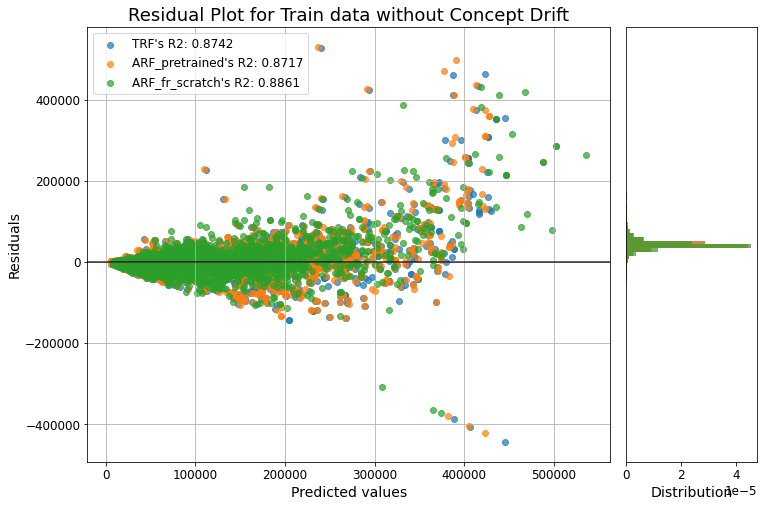

In [24]:
rg_pred_res['train']['model']['TRF'] = trf_rg
rg_pred_res['train']['model']['ARF_pretrained'] = arf_rg
rg_pred_res['train']['model']['ARF_fr_scratch'] = arf_rg_trained_fr_scratch

params = {
    'pred_records': rg_pred_res['train'],
    'X': X_train,
    'y': y_train,
    'data_pp': data_pp,
    'binwidth': 10000,
    'plot_title': 'Residual Plot for Train data without Concept Drift'
}

measure_performance(**params)

## Test performance

The output compares the generalization performance between TRF and ARF in the offline setting. The output again proves that transfer learning process is **successful** as the R-squared value of both **TRF** and **pretrained ARF** are similar with negligible difference. The generalization performance of **ARF that is trained from scratch** is lower than the **pretrained ARF** with a R-squared value difference of 2%.

Performing predictions: 100%|████████████| 1094/1094 [00:00<00:00, 1344.13it/s]


,TRF,ARF_pretrained,ARF_fr_scratch,TRF - ARF_pretrained,TRF - ARF_fr_scratch,ARF_pretrained - ARF_fr_scratch
mse,7.084636e+08,7.401099e+08,8.438274e+08,-3.164626e+07,-1.353638e+08,-1.037175e+08
mae,1.224361e+04,1.223961e+04,1.337306e+04,4.000500e+00,-1.129455e+03,-1.133455e+03
r2,8.946000e-01,8.899000e-01,8.745000e-01,4.700000e-03,2.010000e-02,1.540000e-02


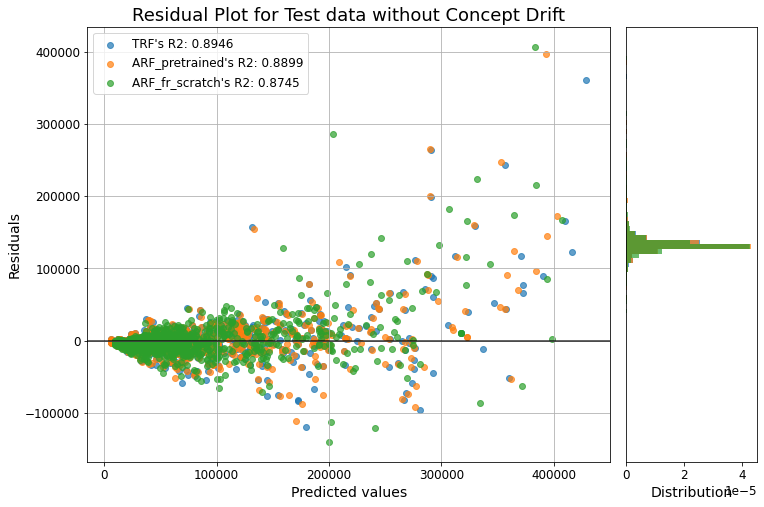

In [25]:
rg_pred_res['test']['model']['TRF'] = trf_rg
rg_pred_res['test']['model']['ARF_pretrained'] = arf_rg
rg_pred_res['test']['model']['ARF_fr_scratch'] = arf_rg_trained_fr_scratch

params = {
    'pred_records': rg_pred_res['test'],
    'X': X_test,
    'y': y_test,
    'data_pp': data_pp,
    'binwidth': 10000,
    'plot_title': 'Residual Plot for Test data without Concept Drift'
}

measure_performance(**params)

The difference of R-squared in the offline set is calculated by substracting the training R-squared score with the testing R-squared score for each set.

<table>
    <tr>
        <th style="text-align:left;">Model type</th>
        <th style="text-align:left;">Diff R-squared in Offline set</th>
    </tr>
    <tr>
        <td style="text-align:left;">TRF</td>
        <td style="text-align:center;">0.8742 - 0.8946 = -0.0204 (-2.04%)</td>
    </tr>
    <tr>
        <td style="text-align:left;">Pre-trained ARF</td>
        <td style="text-align:center;">0.8717 - 0.8899 = -0.0182 (-1.82%)</td>
    </tr>
    <tr>
        <td style="text-align:left;">ARF trained from scratch</td>
        <td style="text-align:center;">0.8861 - 0.8745 = 0.0116 (1.16%)</td>
    </tr>
</table>

The models do not suffer serious overfitting issues even if the hyperparameters used were the same as the ones in the experiment. 

Even though **ARF model that is trained from scratch** performs as good as **pretrained ARF**, the **pretrained ARF**'s base learners' tree structures . 

The result below shows that all the base learners of **ARF model that is trained from scratch** are deeper than the base learners of **pretrained ARF**. It means that the **pretrained ARF** can still perform as good as **ARF model that is trained from scratch** even if the tree height is fixed at 15. Hence, **pretrained ARF** is chosen over **ARF model that is trained from scratch** since it requires lesser memory.

All the tree heights are 15 since the `max_depth` parameter of TRF model, that is used to perform transfer learning,  is set to 15.

In [26]:
models = {
    'TRF': trf_rg,
    'ARF_fr_scratch': arf_rg_trained_fr_scratch,
    'ARF_pretrained': arf_rg
}


analyze_trees(models)

1    2    3    4    5    6    7    8    9    10  \
Model          Properties                                                      
TRF            total_nodes  467  417  349  399  419  439  397  399  447  413   
               max_height    15   15   15   15   15   15   15   15   15   15   
ARF_fr_scratch total_nodes  725  785  767  871  831  753  793  783  845  817   
               max_height    19   17   24   21   17   19   21   22   20   22   
ARF_pretrained total_nodes  467  417  349  399  419  439  397  399  447  413   
               max_height    15   15   15   15   15   15   15   15   15   15   

                             11   12   13   14   15  
Model          Properties                            
TRF            total_nodes  393  433  451  431  349  
               max_height    15   15   15   15   15  
ARF_fr_scratch total_nodes  869  783  845  797  761  
               max_height    23   21   20   26   24  
ARF_pretrained total_nodes  393  433  451  431  349  
               max_height    15   15   15   15   15


Total nodes:



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Model,,,,,,,,,,,,,,,
TRF,467,417,349,399,419,439,397,399,447,413,393,433,451,431,349
ARF_fr_scratch,725,785,767,871,831,753,793,783,845,817,869,783,845,797,761
ARF_pretrained,467,417,349,399,419,439,397,399,447,413,393,433,451,431,349



Maximum height:



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Model,,,,,,,,,,,,,,,
TRF,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
ARF_fr_scratch,19,17,24,21,17,19,21,22,20,22,23,21,20,26,24
ARF_pretrained,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15


# Conclusion

As a conclusion, the TRF is chosen as the application model because:
1. The performance of the TRF regressor is better than ARF regressor during initial training. 
2. Though the ARF regressor's performance is better than TRF regressor in online settings, the extremely poor ARF model's initial performance outweights this advantage.

As a conclusion, the pre-trained ARF is chosen as the application model because:
1. The performance of the pre-trained ARF regressor is better than TRF regressor during initial training. 
2. The performance of the ARF regressor is better than TRF regressor under the influence of data drift or concept drift. This has already proven in the experiment at *FYP2_ARF_RG_Performance_Analysis.ipynb*.
3. The pre-trained ARF regressor is chosen over ARF regressor that is trained from scratch since it requires lesser memory.

*Others*: The cell below trains the car price model with the test samples and converts to dictionary in 10 increments. The purpose is to validate the tree SHAP explainer. The detail can be found in *FYP2_Explainer_Validation.ipynb*. 

In [27]:
from arf_to_dict_conversion import extract_rg_arf
from general_utils import serialize_arf
import json

# Load adaptive random forest
with open(os.path.join(OUT_FOLDER_PATH, 'arf_rg.pkl'), 'rb') as f:
    arf_rg_tmp = pickle.load(f)

X_test_d_pp = data_pp.preprocess(X_test)
increment = 10
checkpoints  = np.linspace(0, len(X_test_d_pp), num=increment+1, endpoint=True).astype(np.int64)

EXP_DIR = 'outputs/explainer_validation/car_price'
os.makedirs(EXP_DIR, exist_ok=True)

for idx in range(1, len(checkpoints)):
    start, end = (checkpoints[idx-1], checkpoints[idx])
    arf_rg_tmp, _ = train_arf_rg(arf_rg_tmp, X_test_d_pp[start:end], y_test[start:end])
    cp_arf_dict = extract_rg_arf(arf_rg_tmp, X_test_d_pp.columns.tolist())
    # Serialize the dictionary to convert to JSON
    cp_arf_dict_serializable = serialize_arf(cp_arf_dict)
    # Export to JSON
    with open(os.path.join(EXP_DIR, f'arf_rg_{idx}.json'), 'w') as f:
        json.dump(cp_arf_dict_serializable, f)

Training adaptive random forest algorithm: 100%|█| 109/109 [00:08<00:00, 12.82i
Training adaptive random forest algorithm: 100%|█| 109/109 [00:04<00:00, 26.40i
Training adaptive random forest algorithm: 100%|█| 110/110 [00:02<00:00, 44.54i
Training adaptive random forest algorithm: 100%|█| 109/109 [00:01<00:00, 69.20i
Training adaptive random forest algorithm: 100%|█| 110/110 [00:01<00:00, 58.75i
Training adaptive random forest algorithm: 100%|█| 109/109 [00:01<00:00, 58.12i
Training adaptive random forest algorithm: 100%|█| 109/109 [00:01<00:00, 62.51i
Training adaptive random forest algorithm: 100%|█| 110/110 [00:01<00:00, 59.69i
Training adaptive random forest algorithm: 100%|█| 109/109 [00:02<00:00, 54.17i
Training adaptive random forest algorithm: 100%|█| 110/110 [00:01<00:00, 56.87i
